An example to explore the differences between 3 "pooling" approaches using simulated data. The "partial pooling" approach is made possible with a hierachical model. The context to explore this topic is a survival rate analysis for tadpoles in ponds. The crux of the question of pooling is whether or not we expect the survival rate to be dependant on which pool the data is taken from.

* Complete pooling
    * We don't expect the data to be pond dependant, so fit for a single model intercept. We will see underfitting, because information will be smeared across the different ponds.
* No pooling
    * We treat each pond independently and fit an intercept for each pond - no information is shared between ponds and we will likely see overfitting, especially for ponds with a small sample size.
* Partial pooling
    * By leveraging a multi-level model we can share information between ponds whilst also fitting a intercept for each pond, balancing over- and under-fitting.


The Partial Pooling model:

s ~ binomial(n,p)
where S is the number of survivors out of the n tadpoles in the pond

p ~ logistic(alpha[i])
where alpha is the vector of intercepts, one for each pond

alpha[i] ~ normal(mu,sigma)
where mu,sigma are the average and std of the log-odds of survival in the entire population of ponds



In [284]:
import numpy as np
import stan
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [285]:
def logistic(x:list) -> list:
    return 1 / (1 + np.exp(-x))

In [286]:
# generating simulated data by first defining underlying pond population attributes to be aimed for by the model
np.random.seed = 0
mu = 1.4
sigma = 1.5
n_ponds = 60   # make divisible by 4
n_cut_a = int(n_ponds/4)
n_cut_b = int(2*n_cut_a)
n_cut_c = int(3*n_cut_a)

# 60 ponds with n[i] tadpoles
n = [item for sublist in [[i]*n_cut_a for i in [5,10,25,35]] for item in sublist]
print(n)

# sample an alpha value for each of the 60 ponds using the gauss distribution defined by mu,sigma
alpha_true = np.random.normal(mu,sigma,(n_ponds,))

# simulate survivors
p_true = logistic(alpha_true)    # logistic function
s = np.random.binomial(n,p_true)
print(s)


[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]
[ 5  5  2  5  2  0  5  2  5  5  4  5  4  4  5  7 10  9  9 10  5  7  7  6
  9  9  6  4 10  1 21 21 25  7 24 18 16 16 12 23 20 19 15 17 19 26  7 11
 34 18  8 24 31 27 32 15 33 29 31 31]


In [287]:
# The probabilities that would arise from the no-pooling approach are very simple to evaluate:
p_no_pool = s / n   # vector elem-wise divide

In [288]:
# fit the partial-pooling model
model = '''
data {
    int<lower=0> N;     // num ponds
    int<lower=0> n[N];  // initial num tadpoles in each pond
    int<lower=0> s[N];  // num of survivors
}
parameters {
    real mu;
    real <lower=0> sigma;
    real alpha[N];
}
model {
    mu ~ normal(0,1);
    sigma ~ cauchy(0,1);

    alpha ~ normal(mu, sigma);
    s ~ binomial(n, inv_logit(alpha));

    // for (pond in 1:N) {
    //     alpha[pond] ~ normal(mu, sigma);
    //     s[pond] ~ binomial(n[pond], inv_logit(alpha[pond]));
    // }
}
generated quantities {
    vector[N] s_hat;
    for (pond in 1:N) {
        s_hat[pond] = binomial_rng(n[pond], inv_logit(alpha[pond]));
    }
}
'''
posterior = stan.build(program_code=model,data= {
    "N" : n_ponds,
    "n" : n,
    "s" : s
})
fit = posterior.sample(num_chains=4,num_warmup=1000, num_samples=10000, num_thin=5)
az_fit = az.from_pystan(posterior=fit,
                        posterior_model=posterior,
                        observed_data="s",
                        posterior_predictive="s_hat")

Building...

In file included from /Users/echapman/Library/Caches/httpstan/4.9.1/models/nodpbxia/model_nodpbxia.cpp:2:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /

20 warnings generated.
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_nvec

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

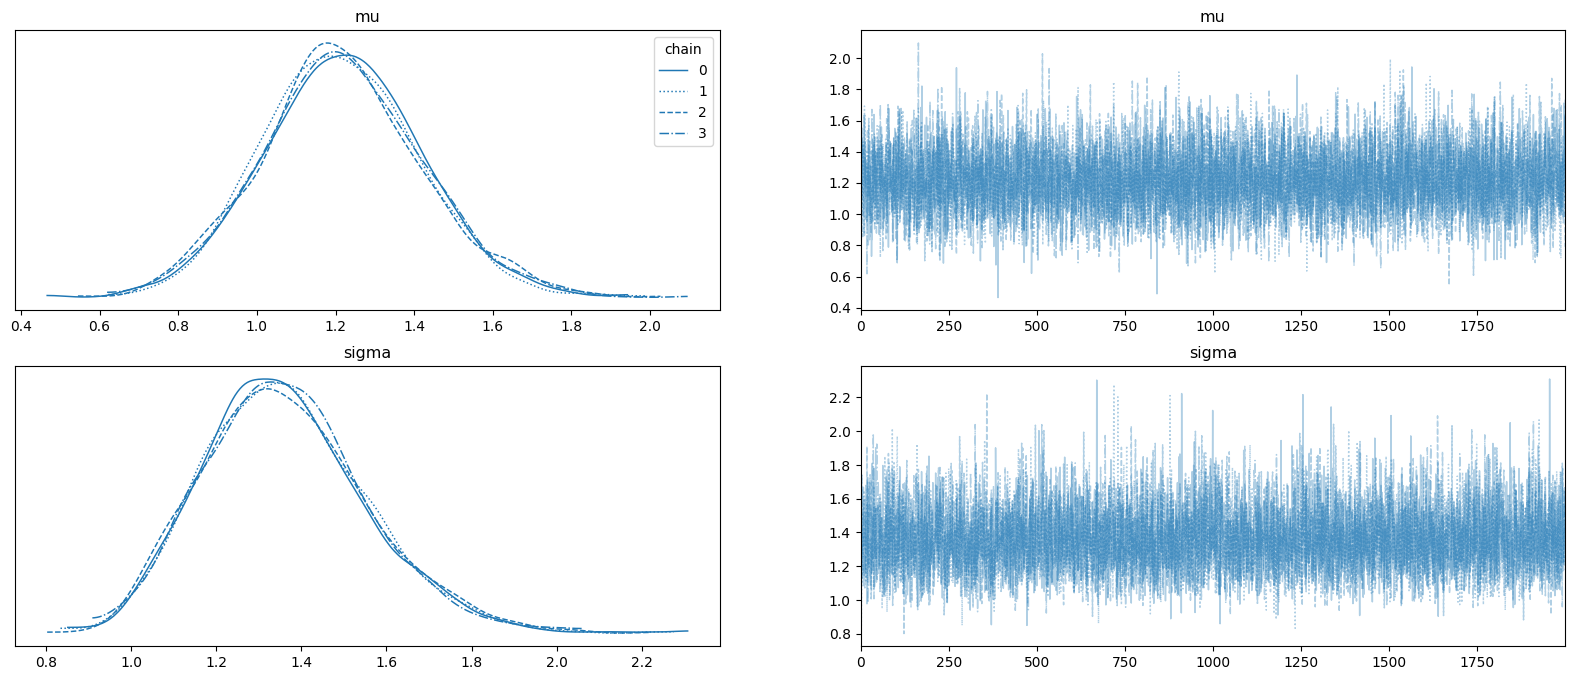

In [289]:
az.plot_trace(az_fit, ["mu","sigma"], figsize=(20,8), legend=True)

In [290]:
mu_fit = np.mean(np.mean(az_fit.posterior.mu.to_numpy(),axis=0), axis=0)
sigma_fit = np.mean(np.mean(az_fit.posterior.sigma.to_numpy(),axis=0), axis=0)
print(f'mu_hat: {mu_fit}, mu: {mu} \n sigma_hat: {sigma_fit}, sigma: {sigma}')
alpha_fit = np.mean(az_fit.posterior.alpha.to_numpy(),axis=0)
p_partial_pool = logistic(np.mean(alpha_fit,axis=0))

mu_hat: 1.2165119170757135, mu: 1.4 
 sigma_hat: 1.3618880255706904, sigma: 1.5


Having fit the partially pooled model and the model with no pooling, they may be compared with one another and with the ground truth. The following comparison is carried out at the probability level:

In [291]:
e_no_pool = np.abs(p_true - p_no_pool)
e_partial_pool = np.abs(p_true - p_partial_pool)

e_no_pool_ave_a = np.mean(e_no_pool[:n_cut_a])
e_no_pool_ave_b = np.mean(e_no_pool[n_cut_a:n_cut_b])
e_no_pool_ave_c = np.mean(e_no_pool[n_cut_b:n_cut_c])
e_no_pool_ave_d = np.mean(e_no_pool[n_cut_c:])

e_partial_pool_ave_a = np.mean(e_partial_pool[:n_cut_a])
e_partial_pool_ave_b = np.mean(e_partial_pool[n_cut_a:n_cut_b])
e_partial_pool_ave_c = np.mean(e_partial_pool[n_cut_b:n_cut_c])
e_partial_pool_ave_d = np.mean(e_partial_pool[n_cut_c:])

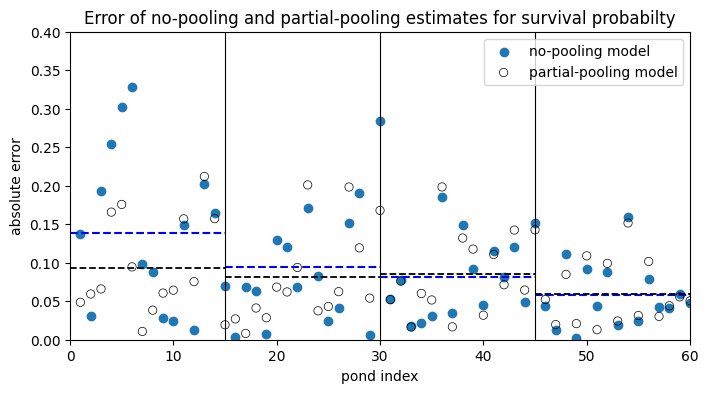

In [293]:
fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(range(1,n_ponds+1),e_no_pool,label='no-pooling model')
clear = MarkerStyle(marker='o',fillstyle='none')
ax.scatter(range(1,n_ponds+1),e_partial_pool,marker=clear,c='black',linewidths=0.5,label='partial-pooling model')
# model error means for each pond size
ax.plot([0,n_cut_a],[e_no_pool_ave_a,e_no_pool_ave_a],'--b')
ax.plot([0,n_cut_a],[e_partial_pool_ave_a,e_partial_pool_ave_a],'--k',linewidth=1.3)
ax.plot([n_cut_a,n_cut_b],[e_no_pool_ave_b,e_no_pool_ave_b],'--b')
ax.plot([n_cut_a,n_cut_b],[e_partial_pool_ave_b,e_partial_pool_ave_b],'--k',linewidth=1.3)
ax.plot([n_cut_b,n_cut_c],[e_no_pool_ave_c,e_no_pool_ave_c],'--b')
ax.plot([n_cut_b,n_cut_c],[e_partial_pool_ave_c,e_partial_pool_ave_c],'--k',linewidth=1.3)
ax.plot([n_cut_c,n_ponds],[e_no_pool_ave_d,e_no_pool_ave_d],'--b')
ax.plot([n_cut_c,n_ponds],[e_partial_pool_ave_d,e_partial_pool_ave_d],'--k',linewidth=1.3)
ax.plot([n_cut_a,n_cut_a],[0,1],'-k',linewidth=0.8)
ax.plot([n_cut_b,n_cut_b],[0,1],'-k',linewidth=0.8)
ax.plot([n_cut_c,n_cut_c],[0,1],'-k',linewidth=0.8)
ax.set_xlim((0,n_ponds))
ax.set_ylim((0,0.4))
ax.set_ylabel('absolute error')
ax.set_xlabel('pond index')
ax.set_title('Error of no-pooling and partial-pooling estimates for survival probabilty')
ax.legend()